In [1]:
import tensorflow as tf
import numpy as np
import os
import shutil
from pathlib import Path
from datetime import datetime
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

2025-09-06 22:47:01.716237: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-06 22:47:01.720322: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-06 22:47:01.734247: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757177221.759194   38515 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757177221.766351   38515 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757177221.783442   38515 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
def merge_folders_advanced(source_parent, destination, conflict_strategy="rename"):
    """
    Merge folders with multiple conflict resolution strategies.
    
    conflict_strategy options:
    - "rename": Append source folder name (default)
    - "overwrite": Replace existing files
    - "skip": Keep existing files
    - "timestamp": Append timestamp
    """
    
    source_parent = Path(source_parent)
    destination = Path(destination)
    destination.mkdir(parents=True, exist_ok=True)
    
    source_folders = [f for f in source_parent.iterdir() if f.is_dir()]
    files_processed = 0
    conflicts_resolved = 0
    
    for source_folder in source_folders:
        for root, dirs, files in os.walk(source_folder):
            root_path = Path(root)
            relative_path = root_path.relative_to(source_folder)
            dest_dir = destination / relative_path
            dest_dir.mkdir(parents=True, exist_ok=True)
            
            for file in files:
                source_file = root_path / file
                dest_file = dest_dir / file
                files_processed += 1
                
                if dest_file.exists():
                    conflicts_resolved += 1
                    
                    if conflict_strategy == "overwrite":
                        # Simply overwrite
                        pass
                    elif conflict_strategy == "skip":
                        continue
                    elif conflict_strategy == "timestamp":
                        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
                        stem, suffix = dest_file.stem, dest_file.suffix
                        dest_file = dest_dir / f"{stem}_{timestamp}{suffix}"
                    else:  # "rename" (default)
                        stem, suffix = dest_file.stem, dest_file.suffix
                        dest_file = dest_dir / f"{stem}_{source_folder.name}{suffix}"
                
                shutil.copy2(source_file, dest_file)
    
    print(f"Merge completed!")
    print(f"Folders processed: {len(source_folders)}")
    print(f"Files processed: {files_processed}")
    print(f"Conflicts resolved: {conflicts_resolved}")

# Usage examples
# merge_folders_advanced("/path/to/source", "/path/to/dest")  # Default: rename
# merge_folders_advanced("/path/to/source", "/path/to/dest", "overwrite")
# merge_folders_advanced("/path/to/source", "/path/to/dest", "skip")
# merge_folders_advanced("/path/to/source", "/path/to/dest", "timestamp")

In [3]:
merge_folders_advanced("all_images//", "mnist_extend/")

Merge completed!
Folders processed: 10
Files processed: 4507
Conflicts resolved: 4507


In [4]:
# 1. Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Expand MNIST dims to match grayscale (H, W, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Normalize MNIST
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# 2. Load your custom dataset
custom_data = tf.keras.utils.image_dataset_from_directory(
    "mnist_extend/", 
    shuffle=True,
    batch_size=None,   # Return single examples, not batches
    color_mode='grayscale',
    image_size=(28, 28)
)

# Convert to NumPy arrays
custom_images = []
custom_labels = []

for img, label in custom_data:
    custom_images.append(img.numpy())
    custom_labels.append(label.numpy())

custom_images = np.array(custom_images) / 255.0
custom_labels = np.array(custom_labels)

# 3. Function to mix datasets
def combine_datasets(x_train, y_train, x_test, y_test,
                     custom_images, custom_labels,
                     train_ratio=0.8):
    """
    train_ratio: proportion of custom dataset that goes into train set
    """
    # Shuffle custom dataset
    idx = np.arange(len(custom_images))
    np.random.shuffle(idx)
    custom_images = custom_images[idx]
    custom_labels = custom_labels[idx]

    # Split custom dataset
    split = int(len(custom_images) * train_ratio)
    custom_train_x, custom_test_x = custom_images[:split], custom_images[split:]
    custom_train_y, custom_test_y = custom_labels[:split], custom_labels[split:]

    # Combine with MNIST
    x_train_combined = np.concatenate([x_train, custom_train_x], axis=0)
    y_train_combined = np.concatenate([y_train, custom_train_y], axis=0)

    x_test_combined = np.concatenate([x_test, custom_test_x], axis=0)
    y_test_combined = np.concatenate([y_test, custom_test_y], axis=0)

    # Shuffle combined datasets
    train_idx = np.arange(len(x_train_combined))
    np.random.shuffle(train_idx)
    x_train_combined, y_train_combined = x_train_combined[train_idx], y_train_combined[train_idx]

    test_idx = np.arange(len(x_test_combined))
    np.random.shuffle(test_idx)
    x_test_combined, y_test_combined = x_test_combined[test_idx], y_test_combined[test_idx]

    return (x_train_combined, y_train_combined), (x_test_combined, y_test_combined)


# Example usage: 70% of custom dataset in train, 30% in test
(train_x, train_y), (test_x, test_y) = combine_datasets(
    x_train, y_train, x_test, y_test,
    custom_images, custom_labels,
    train_ratio=0.7
)

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

Found 9371 files belonging to 10 classes.


2025-09-06 22:47:07.817782: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-09-06 22:47:09.827011: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(66559, 28, 28, 1) (66559,)
(12812, 28, 28, 1) (12812,)


In [5]:
model = Sequential([
    Flatten(input_shape=(28, 28, 1)),   
    Dense(128, activation='relu'),  
    Dense(64, activation='relu'),    
    Dense(10, activation='softmax') 
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_x, train_y, epochs=5, batch_size=128, validation_split=0.1)

test_loss, test_acc = model.evaluate(test_x, test_y)
print(f"Test accuracy: {test_acc:.4f}")

/home/istiaqfuad/Desktop/ai_lab/.venv/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-09-06 22:47:10.380859: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 187855808 exceeds 10% of free system memory.


Epoch 1/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8520 - loss: 0.4945 - val_accuracy: 0.9031 - val_loss: 0.3092
Epoch 2/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9228 - loss: 0.2456 - val_accuracy: 0.9213 - val_loss: 0.2454
Epoch 3/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9414 - loss: 0.1846 - val_accuracy: 0.9303 - val_loss: 0.2185
Epoch 4/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9504 - loss: 0.1528 - val_accuracy: 0.9422 - val_loss: 0.1892
Epoch 5/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9575 - loss: 0.1308 - val_accuracy: 0.9437 - val_loss: 0.1875
401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9192 - loss: 0.2600
Test accuracy: 0.9192


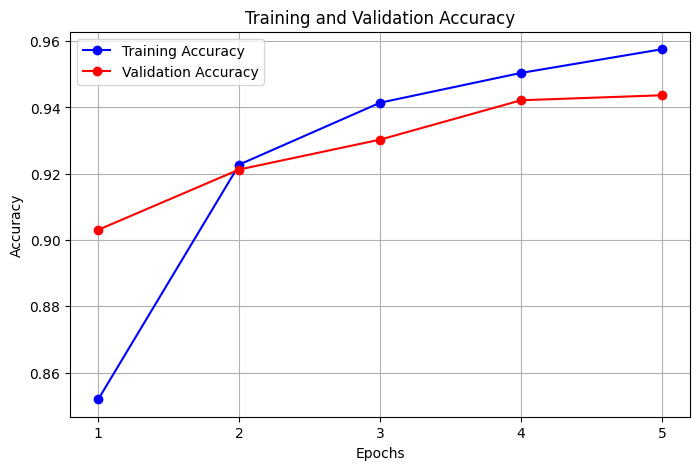

In [6]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()

401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


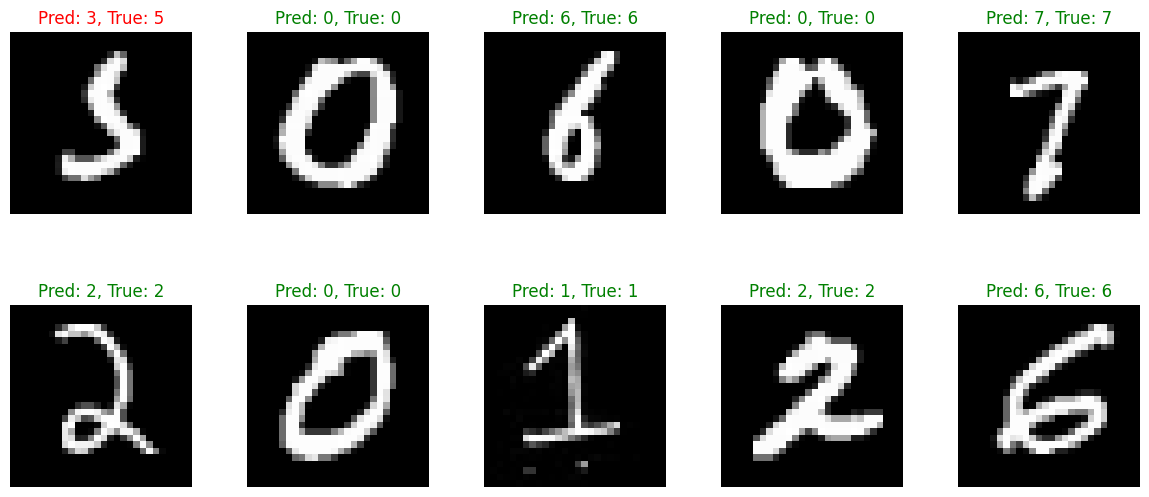

In [10]:
predictions = model.predict(test_x)

random_idxs = np.random.choice(len(test_x), size=10, replace=False)

plt.figure(figsize=(12, 5))
for i, idx in enumerate(random_idxs):
    plt.subplot(2, 5, i+1)
    plt.imshow(test_x[idx].reshape(28, 28), cmap="gray")

    pred_label = np.argmax(predictions[idx])   # predicted class
    true_label = test_y[idx]                   # actual integer label

    color = "green" if pred_label == true_label else "red"
    plt.title(f"Pred: {pred_label}, True: {true_label}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.subplots_adjust(hspace=0.5) 
plt.show()